# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm

!pip install torchmetrics
import torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.4/891.4 kB 36.8 MB/s eta 0:00:00


# Getting the Dataset


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

100%|██████████| 5.20G/5.20G [03:58<00:00, 23.4MB/s]

Extracting model files...


Path to dataset files: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


In [3]:
import os

# List files in the dataset directory
dataset_files = os.listdir(path)
print("Files in the dataset:", dataset_files)


Files in the dataset: ['HAM10000_metadata.csv', 'hmnist_8_8_L.csv', 'ham10000_images_part_1', 'ham10000_images_part_2', 'HAM10000_images_part_2', 'HAM10000_images_part_1', 'hmnist_8_8_RGB.csv', 'hmnist_28_28_RGB.csv', 'hmnist_28_28_L.csv']


# Viewing the Images

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Display a few images
image_folder = os.path.join(path, "HAM10000_images_part_1")  # Adjust if necessary
sample_images = os.listdir(image_folder)[10:20]  # Show first 5 images

plt.figure(figsize=(12, 8))
for idx, img_file in enumerate(sample_images):
    img_path = os.path.join(image_folder, img_file)
    img = mpimg.imread(img_path)

    plt.subplot(0, 5, idx + 1)
    plt.imshow(img)
    plt.title(img_file)
    plt.axis("off")

plt.show()

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1200x800 with 0 Axes>

# Inspecting the size of the images

In [6]:
import cv2

In [7]:
# Define the path to the image folder (adjust if needed based on output of previous step)
image_folder = os.path.join(path, "HAM10000_images_part_1")

# List the first few images in this folder
sample_images = os.listdir(image_folder)
print("Sample images:", sample_images[:5])

image_path = os.path.join(image_folder, sample_images[0])
# Load image and check dimensions
img = cv2.imread(image_path)
height, width, channels = img.shape
print("Image size:", (width, height))

Sample images: ['ISIC_0025368.jpg', 'ISIC_0028094.jpg', 'ISIC_0024890.jpg', 'ISIC_0027718.jpg', 'ISIC_0024591.jpg']
Image size: (600, 450)


# Define a custom Dataset class to integrate our data to PyTorch

In [8]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((244, 244)),  # Resize images to 64x64
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjust based on your dataset stats
])

In [9]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class SkinCancerDataset(Dataset):


    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Get the image path and label
        img_name = os.path.join(self.img_dir, self.annotations.iloc[idx, 1]+".jpg")
        image = Image.open(img_name).convert("RGB")

        # Define mapping from var1 short codes to labels
        label_mapping = {
            "akiec": 0,  # Actinic keratoses and intraepithelial carcinoma / Bowen's disease
            "bcc": 1,    # Basal cell carcinoma
            "bkl": 2,    # Benign keratosis-like lesions
            "df": 3,     # Dermatofibroma
            "mel": 4,    # Melanoma
            "nv": 5,     # Melanocytic nevi
            "vasc": 6    # Vascular lesions
        }

        # Convert the label to an integer
        label = int(label_mapping.get(self.annotations.iloc[idx, 2], -1))

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

merging part1 and part 2 of images into one directory

In [10]:
import os
import shutil

# Paths to original folders
path_part_1 = os.path.join(path, "HAM10000_images_part_1")
path_part_2 = os.path.join(path, "HAM10000_images_part_2")
combined_dir = os.path.join(path, "HAM10000_images_combined")

# Create combined directory if it doesn't exist
os.makedirs(combined_dir, exist_ok=True)

# Move images from part_1
for filename in os.listdir(path_part_1):
    source = os.path.join(path_part_1, filename)
    destination = os.path.join(combined_dir, filename)
    shutil.move(source, destination)

# Move images from part_2
for filename in os.listdir(path_part_2):
    source = os.path.join(path_part_2, filename)
    destination = os.path.join(combined_dir, filename)
    shutil.move(source, destination)

print("Images from both folders have been merged into", combined_dir)

Images from both folders have been merged into /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_images_combined


Loading and Splitting the dataset into training, validation, and testing

In [11]:
csv_file = os.path.join(path, "HAM10000_metadata.csv")
img_dir = os.path.join(path, "HAM10000_images_combined")

# Load the dataset with transformations
dataset = SkinCancerDataset(csv_file=csv_file, img_dir=img_dir, transform=transform)

# Split into training, validation, and testing sets
train_size = int(0.8 * len(dataset))  # 80% training
val_size = int(0.1 * len(dataset))    # 10% validation
test_size = len(dataset) - train_size - val_size  # Remaining 10% for testing

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [12]:
!ls /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_images_combined

ISIC_0024306.jpg  ISIC_0026309.jpg  ISIC_0028312.jpg  ISIC_0030315.jpg	ISIC_0032318.jpg
ISIC_0024307.jpg  ISIC_0026310.jpg  ISIC_0028313.jpg  ISIC_0030316.jpg	ISIC_0032319.jpg
ISIC_0024308.jpg  ISIC_0026311.jpg  ISIC_0028314.jpg  ISIC_0030317.jpg	ISIC_0032320.jpg
ISIC_0024309.jpg  ISIC_0026312.jpg  ISIC_0028315.jpg  ISIC_0030318.jpg	ISIC_0032321.jpg
ISIC_0024310.jpg  ISIC_0026313.jpg  ISIC_0028316.jpg  ISIC_0030319.jpg	ISIC_0032322.jpg
ISIC_0024311.jpg  ISIC_0026314.jpg  ISIC_0028317.jpg  ISIC_0030320.jpg	ISIC_0032323.jpg
ISIC_0024312.jpg  ISIC_0026315.jpg  ISIC_0028318.jpg  ISIC_0030321.jpg	ISIC_0032324.jpg
ISIC_0024313.jpg  ISIC_0026316.jpg  ISIC_0028319.jpg  ISIC_0030322.jpg	ISIC_0032325.jpg
ISIC_0024314.jpg  ISIC_0026317.jpg  ISIC_0028320.jpg  ISIC_0030323.jpg	ISIC_0032326.jpg
ISIC_0024315.jpg  ISIC_0026318.jpg  ISIC_0028321.jpg  ISIC_0030324.jpg	ISIC_0032327.jpg
ISIC_0024316.jpg  ISIC_0026319.jpg  ISIC_0028322.jpg  ISIC_0030325.jpg	ISIC_0032328.jpg
ISIC_0024317.jpg  ISIC_0026320.j

# Inspecting the training set


Image batch shape: torch.Size([8, 3, 244, 244])
Label batch shape: torch.Size([8])
Labels: tensor([5, 5, 5, 5, 5, 5, 5, 5])


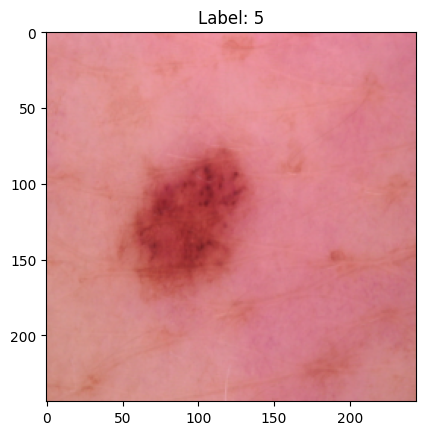

In [12]:
# Set up DataLoader for the training set
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)

# Inspect a single batch of data
for images, labels in train_loader:
    print("Image batch shape:", images.shape)  # Shape of the batch (batch_size, channels, height, width)
    print("Label batch shape:", labels.shape)  # Shape of the labels batch (batch_size,)
    print("Labels:", labels)  # Print the labels

    # Display a single image from the batch using matplotlib
    import matplotlib.pyplot as plt
    img = images[0].permute(1, 2, 0)  # Change channel order for displaying (C, H, W) -> (H, W, C)
    img = img * torch.tensor([0.5, 0.5, 0.5]) + torch.tensor([0.5, 0.5, 0.5])  # If normalized, undo normalization
    img = img.clamp(0, 1)  # Ensure the values are within [0, 1] for display

    plt.imshow(img)
    plt.title(f"Label: {labels[0].item()}")
    plt.show()
    break  # Only display the first batch

In [13]:
# Set up DataLoaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [19]:
from torchvision import models
# Custom VGG16 Model with additional convolutional layer and custom classifier
class CustomVGG16(nn.Module):
    def __init__(self, num_classes):
        super(CustomVGG16, self).__init__()

        # Load pretrained VGG16 model
        vgg16 = models.vgg16(pretrained=True)
        self.features = nn.Sequential(*list(vgg16.features.children()))

        # Freeze VGG16 layers
        for param in self.features.parameters():
            param.requires_grad = False

        # Add custom convolutional layer after the last VGG16 layer
        self.custom_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Custom classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 3 * 3, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        # Pass through VGG16 feature layers
        x = self.features(x)

        # Pass through custom conv layer
        x = self.custom_conv(x)


        # Pass through classifier
        x = self.classifier(x)
        return x


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Number of classes in the dataset
num_classes = 7
model = CustomVGG16(num_classes=num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Training parameters
num_epochs = 15

cuda


In [21]:
import time
while True:
    time.sleep(200)  # Wait for 5 minutes
    print("Keeping session alive...")

KeyboardInterrupt: 

In [22]:

# Training and validation loop
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    print(f"Starting epoch {epoch + 1}/{num_epochs}")

    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_acc_history.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss/len(train_loader):.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    val_acc_history.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {val_accuracy:.2f}%")


Starting epoch 1/15
Epoch [1/15], Training Loss: 0.9250, Training Accuracy: 67.99%
Epoch [1/15], Validation Accuracy: 71.33%
Starting epoch 2/15
Epoch [2/15], Training Loss: 0.7524, Training Accuracy: 73.17%
Epoch [2/15], Validation Accuracy: 71.83%
Starting epoch 3/15
Epoch [3/15], Training Loss: 0.6280, Training Accuracy: 77.17%
Epoch [3/15], Validation Accuracy: 70.73%
Starting epoch 4/15
Epoch [4/15], Training Loss: 0.5358, Training Accuracy: 81.44%
Epoch [4/15], Validation Accuracy: 72.23%
Starting epoch 5/15
Epoch [5/15], Training Loss: 0.4542, Training Accuracy: 83.84%
Epoch [5/15], Validation Accuracy: 73.53%
Starting epoch 6/15
Epoch [6/15], Training Loss: 0.3660, Training Accuracy: 87.04%
Epoch [6/15], Validation Accuracy: 72.23%
Starting epoch 7/15
Epoch [7/15], Training Loss: 0.3136, Training Accuracy: 89.57%
Epoch [7/15], Validation Accuracy: 72.93%
Starting epoch 8/15
Epoch [8/15], Training Loss: 0.2811, Training Accuracy: 90.64%
Epoch [8/15], Validation Accuracy: 72.93%


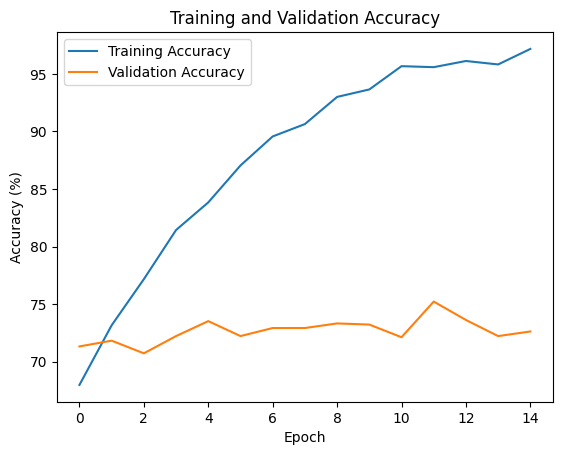

Test Accuracy: 73.65%


In [23]:
# Plotting accuracy
plt.plot(train_acc_history, label="Training Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

# Test the model on the test set
model.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.2f}%")